# Use Quaternions to rotate LiDAR point clouds

This can be used in data augmentation.

I test two packages that contain functions for doing this (method #1 and method #2)

* [pyquaternion](https://github.com/KieranWynn/pyquaternion) - easier to use
* [quarternion](https://github.com/moble/quaternion) - faster

For information on quaternions in general, see [here](http://work.thaslwanter.at/Kinematics/html/04_Quaternions.html#combined-rotations-with-rotation-vectors).

## Method 1 - `pyquaternion`

In [1]:
from pyquaternion import Quaternion
import numpy as np
import quaternion
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# define vectors
origin = [0, 0, 0]
points = [[1, 1, 1],
          [3, 3, 1],
          [4, 4, 4],
          [1, 1, 4],
          [3, 2, 1],
          [0.5, 0.5, 2.5]]

vectors = np.array([origin + point for point in points])

print(vectors)

[[ 0.   0.   0.   1.   1.   1. ]
 [ 0.   0.   0.   3.   3.   1. ]
 [ 0.   0.   0.   4.   4.   4. ]
 [ 0.   0.   0.   1.   1.   4. ]
 [ 0.   0.   0.   3.   2.   1. ]
 [ 0.   0.   0.   0.5  0.5  2.5]]


In [3]:
# define the quaternion to rotate about the z-axis
rot_angle = 10
zquat = Quaternion(axis=[0.0, 0.0, 1.0], degrees=rot_angle)

In [4]:
# rotate the vectors
rot_vectors = []
for vector in vectors:
    r = zquat.rotate(vector[3:])
    v =  np.concatenate((origin, r))
    rot_vectors.append(v)

In [5]:
rot_vectors

[array([ 0.        ,  0.        ,  0.        ,  0.81115958,  1.15845593,  1.        ]),
 array([ 0.        ,  0.        ,  0.        ,  2.43347873,  3.47536779,  1.        ]),
 array([ 0.        ,  0.        ,  0.        ,  3.2446383 ,  4.63382372,  4.        ]),
 array([ 0.        ,  0.        ,  0.        ,  0.81115958,  1.15845593,  4.        ]),
 array([ 0.        ,  0.        ,  0.        ,  2.6071269 ,  2.49056004,  1.        ]),
 array([ 0.        ,  0.        ,  0.        ,  0.40557979,  0.57922797,
         2.5       ])]

## Method 2 - using dtype: `quaternion`

In [6]:
# use the same vectors as above in method #1 (adjusted for package conventions)
origin = [0.]
points = [[1, 1, 1],
          [3, 3, 1],
          [4, 4, 4],
          [1, 1, 4],
          [3, 2, 1],
          [0.5, 0.5, 2.5]]

vectors2 = np.array([origin + point for point in points])

vectors2

array([[ 0. ,  1. ,  1. ,  1. ],
       [ 0. ,  3. ,  3. ,  1. ],
       [ 0. ,  4. ,  4. ,  4. ],
       [ 0. ,  1. ,  1. ,  4. ],
       [ 0. ,  3. ,  2. ,  1. ],
       [ 0. ,  0.5,  0.5,  2.5]])

In [7]:
v = vectors2[1]
axis = [0, 0, 1]    # rotate about the z-axis
rot_angle = 10                  # degrees
theta = np.deg2rad(rot_angle)   # radians

rot_axis = np.array([0.] + axis)
axis_angle = (theta*0.5) * rot_axis/np.linalg.norm(rot_axis)

In [8]:
vec = np.array([np.quaternion(*vi) for vi in vectors])
qlog = quaternion.quaternion(*axis_angle)
q = np.exp(qlog)

In [9]:
# compute the rotation
v_prime = q * vec * np.conjugate(q)
v_prime

array([quaternion(0, 0, 0, 0), quaternion(0, 0, 0, 0),
       quaternion(0, 0, 0, 0), quaternion(0, 0, 0, 0),
       quaternion(0, 0, 0, 0), quaternion(0, 0, 0, 0)], dtype=quaternion)

In [10]:
# convert to compare to method 1 output
rot_vectors2 = quaternion.as_float_array(v_prime)[:, 1:]

# remove leading zeros from method 1 output
rot_vectors1 = np.array(rot_vectors)[:, 3:]

In [11]:
# compare output to method 1
np.array_equal(rot_vectors1, rot_vectors2)

False

## Test and visualise rotation

Use a few simple vectors with clear rotations

Use method 1 as it is slightly easier...

In [12]:
# have a look at the actual values for the original and rotated vectors
for i in zip(vectors, rot_vectors):
    print('Original vector: {}'.format(i[0]))
    print('Rotated vector: {}'.format(i[1]))

Original vector: [ 0.  0.  0.  1.  1.  1.]
Rotated vector: [ 0.          0.          0.          0.81115958  1.15845593  1.        ]
Original vector: [ 0.  0.  0.  3.  3.  1.]
Rotated vector: [ 0.          0.          0.          2.43347873  3.47536779  1.        ]
Original vector: [ 0.  0.  0.  4.  4.  4.]
Rotated vector: [ 0.          0.          0.          3.2446383   4.63382372  4.        ]
Original vector: [ 0.  0.  0.  1.  1.  4.]
Rotated vector: [ 0.          0.          0.          0.81115958  1.15845593  4.        ]
Original vector: [ 0.  0.  0.  3.  2.  1.]
Rotated vector: [ 0.          0.          0.          2.6071269   2.49056004  1.        ]
Original vector: [ 0.   0.   0.   0.5  0.5  2.5]
Rotated vector: [ 0.          0.          0.          0.40557979  0.57922797  2.5       ]


<IPython.core.display.Javascript object>


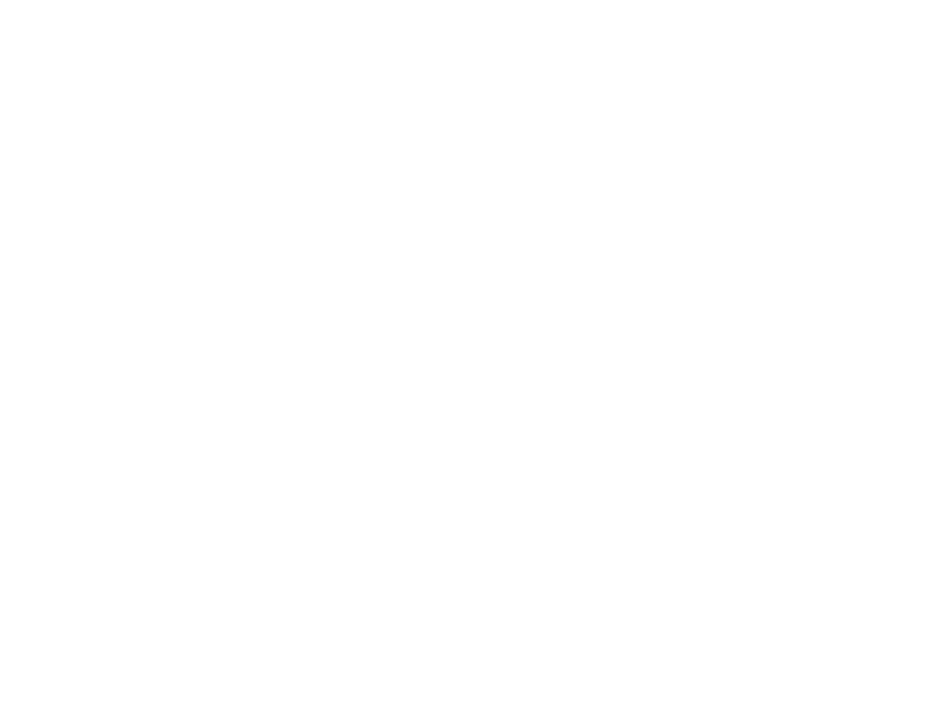

In [13]:
%matplotlib notebook

fig = plt.figure()
fig.set_size_inches(13, 10)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D point cloud rotation - 10 degrees about Z-axis\n'
             'Input: blue vectors with orange points\n'
             'Output: red vectors with green points\n\n')

# show the vectors?
ARROWS = True
    
for vector in vectors:
    if ARROWS:
        ax.quiver(*vector, arrow_length_ratio=0.1, cmap='Blues')
    ax.scatter3D(*vector[3:], c='orange')

for vector in rot_vectors:
    if ARROWS:
        ax.quiver(*vector, arrow_length_ratio=0.1, color='r')
    ax.scatter3D(*vector[3:], c='g')
    
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

# Benchmarking

Compare the two methods in terms of execution speed of datasets of three sizes:

* 1,000 points
* 10,000 points
* 20,000 points
* 1,000,000 points [bonus for **`quaternions`** package only]

In [14]:
# specify the angle by which to rotate all points
rot_angle = 10
theta = np.deg2rad(rot_angle)

In [15]:
# method 1 setup
rot_axis = [0.0, 0.0, 1.0]
zquat = Quaternion(axis=rot_axis, radians=theta)

In [16]:
# method 2 setup
rot_axis = np.array([0.0, 0.0, 0.0, 1.0])    # rotate about the z-axis
#rot_axis = np.array([0.] + axis)
axis_angle = (theta * 0.5) * rot_axis/np.linalg.norm(rot_axis)

qlog = quaternion.quaternion(*axis_angle)
q = np.exp(qlog)

### Generate test data for both methods

In [17]:
## create a random test matrix to compare both methods
n_points_small = [np.random.random(size=(3,)) * 10 for i in range(1000)]
n_points_medium = [np.random.random(size=(3,)) * 10 for i in range(10000)]
n_points_large = [np.random.random(size=(3,)) * 10 for i in range(20000)]
n_points_xlarge = [np.random.random(size=(3,)) * 10 for i in range(1000000)]

In [18]:
# reform the input as required for second method
m_points_small = np.array([np.quaternion(*vi) for vi in n_points_small])
m_points_medium = np.array([np.quaternion(*vi) for vi in n_points_medium])
m_points_large = np.array([np.quaternion(*vi) for vi in n_points_large])
m_points_xlarge = np.array([np.quaternion(*vi) for vi in n_points_xlarge])

#### Sanity check that they are the same

In [19]:
print(len(n_points_small))
n_points_small[0]

1000


array([ 2.10006094,  2.58407429,  0.19857891])

In [20]:
print(m_points_small.shape)
m_points_small[0]
# more decimals in prinout is simply due to the quarternion object's __repr__ method - values are actually the same

(1000,)


quaternion(0, 2.10006094452047, 2.58407428912722, 0.198578909460139)

### Test method 1

In [21]:
%%timeit -n 10 -r 10
for i in range(1000):
    zquat.rotate(n_points_small[i])

65.1 ms ± 6.76 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [22]:
%%timeit -n 10 -r 10
for i in range(10000):
    zquat.rotate(n_points_medium[i])

632 ms ± 49.1 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [23]:
%%timeit -n 10 -r 10
for i in range(20000):
    zquat.rotate(n_points_large[i])

1.18 s ± 36.2 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [24]:
# record results to compare to method 2 (for 10,000 point test)
method_1_results = []
for i in range(10000):
    method_1_results.append(zquat.rotate(n_points_medium[i]))
    
method_1_results = np.array(method_1_results)

### Test method 2

In [25]:
%%timeit -n 10 -r 10
q * m_points_small * np.conjugate(q)

35.8 µs ± 13.9 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [26]:
%%timeit -n 10 -r 10
q * m_points_medium * np.conjugate(q)

276 µs ± 49.7 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [27]:
%%timeit -n 10 -r 10
q * m_points_large * np.conjugate(q)

512 µs ± 95.8 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [28]:
%%timeit -n 10 -r 10
q * m_points_xlarge * np.conjugate(q)

24.2 ms ± 601 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [29]:
method_2_results = q * m_points_medium * np.conjugate(q)

In [30]:
method_2_results_as_array = quaternion.as_float_array(method_2_results)[:, 1:]

###  Quick inpection of outputs

In [31]:
print('Method 2 output:\n')
print(method_1_results)
print('\n\nMethod 2 output:\n')
print(method_2_results_as_array)

Method 2 output:

[[  5.30105261   4.64693202   8.85014752]
 [  1.93800933   8.92376927   7.49076213]
 [  3.5456378    2.76459557   3.26462767]
 ..., 
 [  7.69454754  10.37281806   1.08887119]
 [ -0.51239285   5.90375569   8.84345615]
 [  0.81782345   8.43615258   7.43278979]]


Method 2 output:

[[  5.30105261   4.64693202   8.85014752]
 [  1.93800933   8.92376927   7.49076213]
 [  3.5456378    2.76459557   3.26462767]
 ..., 
 [  7.69454754  10.37281806   1.08887119]
 [ -0.51239285   5.90375569   8.84345615]
 [  0.81782345   8.43615258   7.43278979]]


In [32]:
# compare results of both methods
np.array_equal(method_1_results, method_2_results_as_array)

True

## Summary of Results

Timing rotations for different numbers of points, for the two methods:


Timing rotations for different numbers of points, it seems the `Quaternion.rotate()` function scales linearly with number of points: $O(n)$

Timings for the vectorized method seem to scale by $O(nlogn)$

|# points| Method 1 (ms) | Method 2 ($\mu$s)| speedup|
|-|-|-|-|
|1,000|61|35|1742x|
|10,000|636|354|1796x|
|20,000|1260|604|2086x|
|1,000,000|n/a|25,700| n/a|

In [33]:
# show that method 2 scales roughly with O(nlogn)
points = np.array([1000, 10000, 20000, 1000000])
m2_ = np.array([35, 354, 604, 25700])    # time recorded above in microseconds
m2_ / points*np.log(points)

array([ 0.24177143,  0.32604605,  0.29908532,  0.35505862])

In [34]:
points = np.array([1000, 10000, 20000, 1000000])
m1_ = np.array([61, 636, 1260, np.nan])
m2_ms = m2_ / 1000
import matplotlib.pyplot as plt
#plt.plot(points, m1_)
plt.plot(points*np.log(points), m2_);

In [35]:
# compute speedups
m1_ / m2_ms

array([ 1742.85714286,  1796.61016949,  2086.09271523,            nan])

##  A simple function to use on pointclouds

In [36]:
def rotate_points(pointcloud, angle, axis='z'):
    """Rotate a point cloud by a number of degree around the given axis
    
    pointcloud : a list of numpy arrays,[array(x1, y1, z1), array(x2, y2, z2), ...]
    angle      : the desired angle of rotation in degrees
    axis       : the fixed angle around which the pointcloud is rotated: 'x', 'y' or 'z', optional
    """
    
    #assert isinstance(pointcloud, np.ndarray), "the pointcloud must be a numpy array"
    assert isinstance(angle, float) or isinstance(angle, int), "the angle must be an integer or a float"

    # work with the angle in radians
    angle = np.float64(angle) if isinstance(angle, int) else angle
    angle = np.deg2rad(angle)
    
    # convert coordinates to quaternions
    points = np.array([np.quaternion(*point) for point in pointcloud])
    
    assert isinstance(points, np.ndarray), "the pointcloud isn't properly formed"
    assert isinstance(points[0], quaternion.quaternion), "the pointcloud isn't properly formed"
    
    if axis == 'z':
        rot_axis = np.array([0.0, 0.0, 0.0, 1.0])
    elif axis == 'x':
        rot_axis = np.array([0.0, 1.0, 0.0, 0.0])
    elif axis == 'y':
        rot_axis = np.array([0.0, 0.0, 1.0, 0.0])
    else:
        raise ValueError('axis must be one of x, y, z')
    
    axis_angle = (angle * 0.5) * rot_axis/np.linalg.norm(rot_axis)
    qlog = quaternion.quaternion(*axis_angle)
    q = np.exp(qlog)
    
    return q * points * np.conjugate(q)

In [37]:
rots = rotate_points(n_points_medium, angle=10.0, axis='z')

##  How should the steering angle be adjusted?

Using small angle approximations, if we set the rotation angle to be within [-5, 5], we can use a simple linear scaling for the steering angle adjustment.

The lidar's view goes from -180 to +180. The steering angles lie on the closed interval -30 to + 30.

Let's assume the simple linear relationship:
$$
lidar\_vector = \beta \cdot steering\_angle
$$

In terms of the range of each variable, $\beta$ hold a value of 6.

$$
steering\_angle\_adjustment \approx - \ (\frac{1}{\beta}\cdot rotation\_angle)
$$
 
The negative angle conveys the fact that a rotation of the point cloud to the right would require a car to turn more sharply to the left, and so a larger angle in the negative (left) direction.

Given the ranges and small angle approximations (i.e. they behave nicely in the low nominal range), we can assume a value for $\beta$ in the range of 1-10.

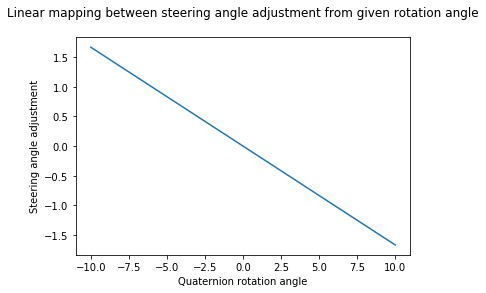

In [38]:
%matplotlib inline

def adj_ang(rot_ang, beta=6):
    return -1 * rot_ang / beta

x = list(range(-10, 11, 1))
y = adj_ang(np.array(x))
plt.plot(x, y)
plt.xlabel('Quaternion rotation angle')
plt.ylabel('Steering angle adjustment')
plt.title('Linear mapping between steering angle adjustment from given rotation angle\n');